[![image-1.png](https://i.postimg.cc/Dw0ChHKk/image-1.png)](https://postimg.cc/LJdkByXN)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:30px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогноз музыкального жанра</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Музыкальный стриминговый сервис "МиФаСоль"
    
__Описание задачи:__ Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы.

__Постановка задачи:__ Разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.
    
__Описание данных:__
    
- файл `train.csv` информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
    
- файл `test.csv` информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных.
    
__Описание полей данных:__
    
- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key - базовый ключ (нота) произведения
- liveness - привлекательность
- loudness - громкость
- mode - указывает на модальность (мажорную или минорную) трека
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- __music_genre__ - музыкальный жанр (целевой признак)

__Оценка результата:__ в данной задаче мы будем использовать метрику f1_micro для оценки качества модели.
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [92]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# константы
RANDOM_SEED = 42

# настройки блокнота
random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка и общая информация данных

</div>

In [3]:
# загрузка информации для обучения:
try:
    train = pd.read_csv('data/train.csv')
    print('Информация для обучения:')
    display(train.head(2))
    display(train.info())
except:
    print('Информация для обучения не доступна')
    
# загрузка информации для тестирования:
try:
    test = pd.read_csv('data/test.csv')
    print('Информация для тестирования:')
    display(test.head(2))
    display(test.info())
except:
    print('Информация для тестирования не доступна')

Информация для обучения:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.480,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.243,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

None

Информация для тестирования:


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


None

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

# Анализ данных

</div>

- `obtained_date`: дата загрузки в сервис, не может влиять на жанр, удаляем этот признак.
- `valence`: привлекательность произведения для пользователей сервиса, так же является субективной мерой, исключаем из дальнейшего анализа,
- `instance_id`: уникальный идентификатор трека, после проверки на уникальность, и преобразования в цельночисленный формат будут переведены в индекс.

In [4]:
# удаляем столбцы 'obtained_date' и 'valence' из обучающего и тестового наборов данных
train = train.drop(['obtained_date', 'valence'], axis=1)
test = test.drop(['obtained_date', 'valence'], axis=1)

__Проверим дубликатов в данных:__

In [5]:
print(f'Общее количество дубликатов в данных: {sum(df.duplicated().sum() for df in [train, test])}')

Общее количество дубликатов в данных: 0


__Проверим уникальность значений признака `instance_id`__

In [6]:
if all(len(df['instance_id'].unique()) == len(df) for df in [train, test]):
    print('Признак instance_id содержит уникальные значения в обоих датасетах')
else: print('Признак instance_id содержит дублирующиеся значения')

Признак instance_id содержит уникальные значения в обоих датасетах


In [7]:
# преобразуем тип данных столбца 'instance_id' в целочисленный
train['instance_id'] = train['instance_id'].astype(int)
test['instance_id'] = test['instance_id'].astype(int)
# устанавливаем признак 'instance_id' в качестве индекса для обучающего и тестового наборов данных
train.set_index('instance_id', inplace=True)
test.set_index('instance_id', inplace=True)

>- Исключены из анализа признаки `obtained_date` и `valence`
>- Признак `instance_id` установлен в качестве индекса

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ числовых признаков

</div>

In [34]:
# общая информация
train.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,20394.0,0.274783,0.321643,0.00000,0.01520,0.120000,0.470000,0.996
danceability,20394.0,0.561983,0.171898,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,20394.0,217289.838825,105509.302428,551.00000,177517.00000,219533.000000,266000.000000,531449.000
energy,20394.0,0.625276,0.251238,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,20394.0,0.159989,0.306503,0.00000,0.00000,0.000144,0.084475,0.996
liveness,20394.0,0.198540,0.166742,0.01360,0.09730,0.130000,0.253000,1.000
loudness,20394.0,-8.552998,5.499917,-44.40600,-10.25575,-7.052000,-5.054000,3.744
speechiness,20394.0,0.091352,0.097735,0.02230,0.03560,0.049050,0.095575,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


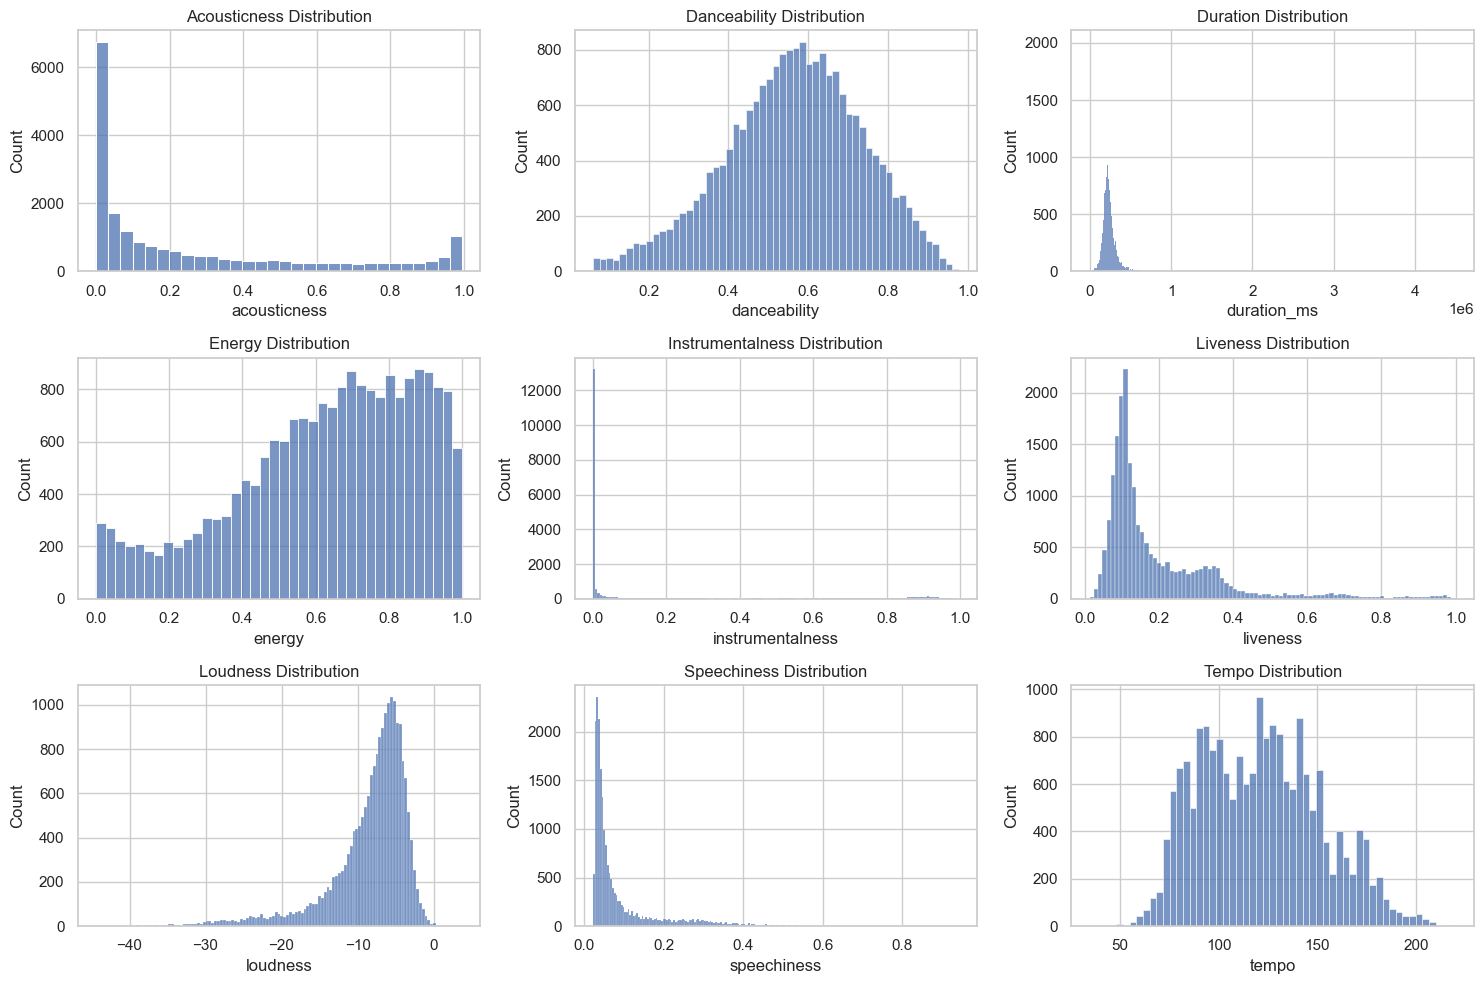

In [18]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

# гистограмма для 'acousticness'
sns.histplot(train['acousticness'], ax=axes[0, 0])
axes[0, 0].set_title('Acousticness Distribution')

# гистограмма для для 'danceability'
sns.histplot(train['danceability'], ax=axes[0, 1])
axes[0, 1].set_title('Danceability Distribution')

# гистограмма для для 'duration_ms'
sns.histplot(train['duration_ms'], ax=axes[0, 2])
axes[0, 2].set_title('Duration Distribution')

# гистограмма для для 'energy'
sns.histplot(train['energy'], ax=axes[1, 0])
axes[1, 0].set_title('Energy Distribution')

# гистограмма для для 'instrumentalness'
sns.histplot(train['instrumentalness'], ax=axes[1, 1])
axes[1, 1].set_title('Instrumentalness Distribution')

# гистограмма для для 'liveness'
sns.histplot(train['liveness'], ax=axes[1, 2])
axes[1, 2].set_title('Liveness Distribution')

# гистограмма для для 'loudness'
sns.histplot(train['loudness'], ax=axes[2, 0])
axes[2, 0].set_title('Loudness Distribution')

# гистограмма для для 'speechiness'
sns.histplot(train['speechiness'], ax=axes[2, 1])
axes[2, 1].set_title('Speechiness Distribution')

# гистограмма для для 'tempo'
sns.histplot(train['tempo'], ax=axes[2, 2])
axes[2, 2].set_title('Tempo Distribution')

# графики
plt.tight_layout()
plt.show()


### duration_ms: продолжительность в милисекундах

В данных присутствуют отрицательные значения и крайне длинные треки:

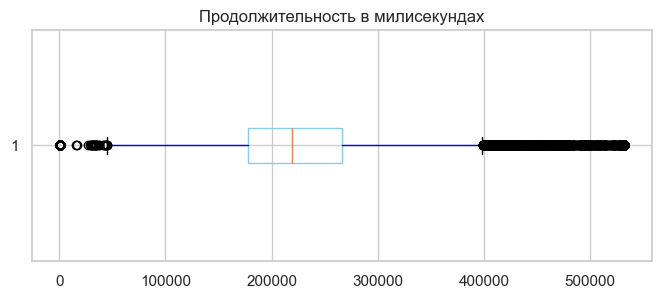

In [33]:
# boxplot для признака vehicle_age
plt.figure(figsize=(8,3))
plt.boxplot(train['duration_ms'], vert=False, boxprops=dict(color='skyblue'), whiskerprops=dict(color='blue'))
plt.grid(True)
plt.title('Продолжительность в милисекундах')
plt.show()

In [31]:
# рассчет верхнего порога аномальных значений
q1 = train['duration_ms'].quantile(0.25)
q3 = train['duration_ms'].quantile(0.75)
upper_threshold = int(q3+3*(q3-q1))
print(f'Порог аномальных значений: {upper_threshold} милисекунд')
# рассчитываем нижний порог для аномальных значений
lower_threshold = q1 - 2*(q3 - q1)
print(f'Нижний порог аномальных значений: {int(lower_threshold)} миллисекунд')

Порог аномальных значений: 531449 милисекунд
Нижний порог аномальных значений: 551 миллисекунд


__Обработка аномальных значений__

In [35]:
# заменяем значения ниже нижнего порога
train['duration_ms'] = np.where(train['duration_ms'] < lower_threshold, lower_threshold, train['duration_ms'])
# заменяем значения выше верхнего порога
train['duration_ms'] = np.where(train['duration_ms'] > upper_threshold, apper_threshold, train['duration_ms'])

# заменяем значения ниже нижнего порога
test['duration_ms'] = np.where(test['duration_ms'] < lower_threshold, lower_threshold, test['duration_ms'])
# заменяем значения выше верхнего порога
test['duration_ms'] = np.where(test['duration_ms'] > upper_threshold, apper_threshold, test['duration_ms'])

__Преобразуем тип данных столбца 'duration_ms' в целочисленный__

In [36]:
train['duration_ms'] = train['duration_ms'].astype(int)
test['duration_ms'] = test['duration_ms'].astype(int)

>Все остальные числовые данные, включая "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", и "speechiness", "tempo", укладываются в пределы допустимых значений и варьируются в рамках нормальных диапазонов для соответствующих музыкальных характеристик. Нет никаких явных аномалий в этих признаках, и они соответствуют типичным значениям для музыкальных данных.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Анализ категориальные признаков

</div>
Проверим уникальные значения в категориальных признаков.

In [38]:
# общая информация 
display(train.describe(include=[object]).T)

,count,unique,top,freq
track_name,20394,18643,Home,11
key,19659,12,G,2304
mode,19888,2,Major,12828
music_genre,20394,10,Blues,2858


__Уникальные значения признака `key`__

In [41]:
train['key'].unique()

array(['D', 'A', 'E', 'G#', 'C', 'D#', 'A#', 'F', 'F#', nan, 'G', 'C#',
       'B'], dtype=object)

>Эти значения представляют собой ноты или аккорды, которые могут быть частью музыкальных произведений. Они соответствуют музыкальным элементам и могут использоваться для определения характера и мелодических особенностей треков.

### Баланс целевой переменной

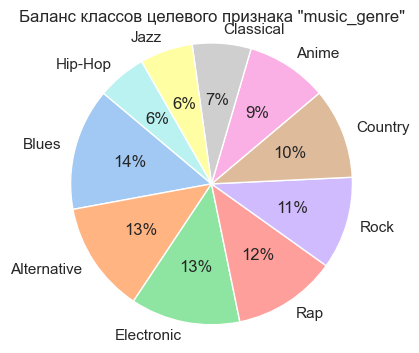

In [54]:
# количество каждого класса
data = train['music_genre'].value_counts()

# метоки классов
labels = data.index
sizes = data.values
colors = sns.color_palette('pastel')

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', startangle=140)
plt.title('Баланс классов целевого признака "music_genre"')
plt.axis('equal')

# отображение диаграммы
plt.show()

>Баланс классов для целевого признака "music_genre" в тренировочных данных не показывает сильного дисбаланса. Визуализация круговой диаграммы показывает, что классы достаточно равномерно представлены в данных, что является положительным для задачи классификации. Нет явного доминирования одного класса над другим, что упрощает обучение модели и ее способность делать предсказания для разных жанров музыки.

<div style="padding:0px 20px 10px;
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400">

## Пропуски в данных

</div>

In [55]:
# функция для рассчето количества пропусков
def isna_sum(df):
    print('Признаки содержащие пропуски:')
    for col in df.columns:
        if df[col].isna().sum()>0:
            print(f'{col}: {df[col].isna().mean():.2%}')

In [56]:
# пропуски в данных для обучения
isna_sum(train)

Признаки содержащие пропуски:
key: 3.60%
mode: 2.48%
tempo: 2.17%


In [57]:
# пропуски в данных для тестирования
isna_sum(test)

Признаки содержащие пропуски:
key: 3.10%
mode: 2.92%
tempo: 2.37%


>Пропуски в данных присутствуют как в тренировочном, так и тестовом наборе данных.
>С учетом того, что удалить данные из тестового набора данных в данной задаче нельзя, попробуем выработать стратегию по заполнению пропусков:
>- создадим копию тренировочного датасета
>- удалим пропуски
>- проверим взаимосвязь признаков

In [58]:
# копия датасета без пропусков
df = train.dropna()

print(f'Общее количество пропусков в данных: {sum(df.isna().sum())}')

Общее количество пропусков в данных: 0


### Корреляции между признаками

Метод PHIK - это статистический метод для определения взаимосвязей между категориальными переменными. Он разработан на основе корреляционного анализа, но специально адаптирован для работы с категориальными данными, которые обычно представлены в виде таблиц сопряженности.

In [59]:
phik_overview = df[[col for col in df.columns if col != 'track_name']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,music_genre
acousticness,1.000000,0.458387,0.295598,0.766578,0.442590,0.096909,0.188614,0.710162,0.026286,0.207558,0.335410,0.658403
danceability,0.458387,1.000000,0.301808,0.515209,0.339896,0.103118,0.132911,0.480074,0.100629,0.336219,0.407936,0.623712
duration_ms,0.295598,0.301808,1.000000,0.305998,0.362986,0.049564,0.152866,0.359252,0.046175,0.217156,0.139921,0.422337
energy,0.766578,0.515209,0.305998,1.000000,0.438574,0.090880,0.260662,0.838452,0.033019,0.239170,0.388336,0.671806
instrumentalness,0.442590,0.339896,0.362986,0.438574,1.000000,0.029922,0.138975,0.498535,0.087474,0.190471,0.217914,0.568069
key,0.096909,0.103118,0.049564,0.090880,0.029922,1.000000,0.057933,0.080208,0.357610,0.117888,0.039206,0.170758
liveness,0.188614,0.132911,0.152866,0.260662,0.138975,0.057933,1.000000,0.202501,0.031851,0.140039,0.082196,0.207030
loudness,0.710162,0.480074,0.359252,0.838452,0.498535,0.080208,0.202501,1.000000,0.019127,0.208318,0.357106,0.679765
mode,0.026286,0.100629,0.046175,0.033019,0.087474,0.357610,0.031851,0.019127,1.000000,0.107284,0.008667,0.295554
speechiness,0.207558,0.336219,0.217156,0.239170,0.190471,0.117888,0.140039,0.208318,0.107284,1.000000,0.185911,0.497169


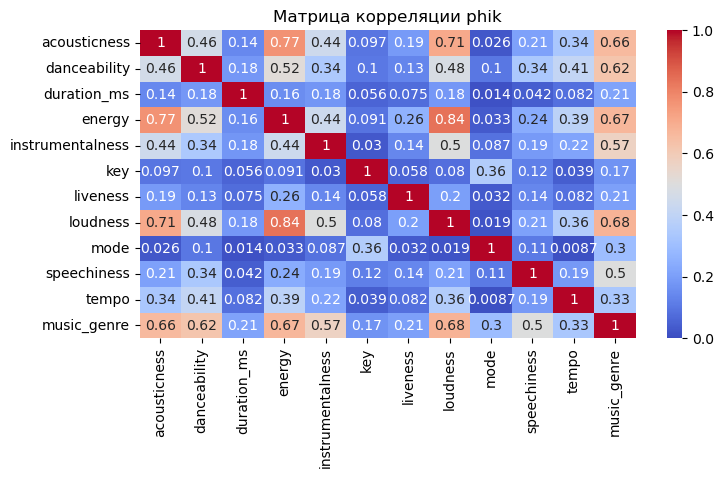

In [16]:
# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

### Пропуски в данных признака `tempo`

Попробуем построить модель LinearRegression для предсказания данного признака на основе данных и наибольшей кореляцией

In [60]:
tempo_df = df[['acousticness', 'danceability', 'energy', 'loudness', 'tempo']]

In [66]:
display(tempo_df.head(2))

,acousticness,danceability,energy,loudness,tempo
instance_id,,,,,
25143,0.480,0.670,0.351,-16.842,101.384
26091,0.243,0.452,0.670,-8.392,113.071


In [68]:
# выбор признаков и целевой переменной
X = tempo_df.drop('tempo', axis=1)
y = tempo_df['tempo']

# разделение данных на тренировочный и тестовый наборы (например, 80% на тренировку и 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# стандартизация признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# построение модели регрессии
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# предсказание значений "tempo" для тестового набора данных
y_pred = model.predict(X_test_scaled)

# оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Square Error (RMSE): {mse**0.5}')
print(f'R-squared (R2): {r2}')


Mean Squared Error (RMSE): 28.94147637341431
R-squared (R2): 0.08718096805997466


Оценим производительность модели, которая просто предсказывает медиану и сравним с обученной ранее моделью

In [70]:
# вычисление медианы на тренировочном наборе данных
median_tempo = np.median(y_train)

# воздание массива предсказаний, в котором каждое предсказание равно медиане
static_predictions = np.full_like(y_test, median_tempo)

# оценка производительности статичной модели
static_mse = mean_squared_error(y_test, static_predictions)
static_r2 = r2_score(y_test, static_predictions)

print(f'Static Model Root Mean Square Error (RMSE): {static_mse**0.5}')
print(f'Static Model R-squared (R2): {static_r2}')

Static Model Root Mean Square Error (RMSE): 30.29873804566274
Static Model R-squared (R2): -0.00044312378762834115


> Модель LinearRegression дает прирост в точности. оучим модель на всех данных и заполним пропуски

In [72]:
# стандартизация признаков
X = scaler.fit_transform(X)
# итоговая модель
model.fit(X, y)

LinearRegression()

__Заполнение пропусков__

In [90]:
def fill_missing_tempo(dataset, model, scaler):
    # строки с пропущенными значениями 'tempo'
    missing_tempo_rows = dataset[dataset['tempo'].isnull()]

    for index, row in missing_tempo_rows.iterrows():
        # извлечение признаков из строки с пропущенным 'tempo'
        features = row[['acousticness', 'danceability', 'energy', 'loudness']].values.reshape(1, -1)
        # стандартизация признаков
        features_scaled = scaler.transform(features)
        # предсказание 'tempo' с использованием обученной модели
        predicted_tempo = model.predict(features_scaled)
        # запись предсказанного значения вместо пропуска
        dataset.at[index, 'tempo'] = predicted_tempo[0]

    return dataset

In [93]:
# заполнение пропусков в train
train = fill_missing_tempo(train, model, scaler)
# заполнение пропусков в test
test = fill_missing_tempo(test, model, scaler)

### Пропуски в данных признака `mode`

Так как с этими признаками не достаточно корелируемых признаков заполним пропуски,наиболее частым значением.

In [98]:
# заполняем пропуски наиболее частым значением
train['mode'].fillna(mode_most_common, inplace=True)
test['mode'].fillna(mode_most_common, inplace=True)

### Пропуски в данных признака `key`

Так как с этими признаками не достаточно корелируемых признаков заполним пропуски, значением 'no_info'.

In [101]:
# заполняем пропуски значением 'no_info'
train['key'].fillna('no_info', inplace=True)
test['key'].fillna('no_info', inplace=True)

__Проверим пропуски в данных:__

In [102]:
print(f'Общее количество пропусков в данных: {sum(sum(col_pas for col_pas in df.isna().sum()) for df in [train, test])}')

Общее количество пропусков в данных: 0


- Мы рассмотрели данные о музыкальных треках, включая различные характеристики, такие как акустичность, танцевальность, энергичность и другие.
   - Выполнили предварительную обработку данных, удалив ненужные признаки, такие как 'obtained_date' и 'valence'.
   - Провели анализ числовых данных и выявили аномалии в столбце 'duration_ms', которые были успешно обработаны.
- Заполнение пропусков:
   - Для признака 'tempo' мы использовали обученную модель регрессии для предсказания пропущенных значений, на основе других характеристик.
   - Для признака 'mode' мы заполнили пропуски наиболее часто встречающимся значением 'Major', так как у нас не было достаточно коррелирующих признаков для предсказания.
- Баланс целевого признака:
   - Мы оценили баланс целевого признака 'music_genre' и убедились, что в данных нет сильного дисбаланса между классами.
